In [1]:
from rdkit import Chem
import pyaniasetools as pya

from ase_interface import ANIENS,ensemblemolecule
import hdnntools as hdt
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

van Der Waals correction will be unavailable. Please install ased3


In [2]:
nets = dict()

ntdir = '/nh/nest/u/jsmith/scratch/Research/ccsd_extrapolation/test_dft_networks/arc11/'
nets['ANI-1x(wb97x/DZ)']= {'cns' : ntdir + 'rHCNO-4.6R_16-3.1A_a4-8.params',
                           'sae' : ntdir + 'sae_wb97x-631gd.dat',
                           'nnf' : ntdir + 'train',
                           'Nn'  : 5}

In [3]:
ens = ensemblemolecule(nets['ANI-1x(wb97x/DZ)']['cns'], nets['ANI-1x(wb97x/DZ)']['sae'], nets['ANI-1x(wb97x/DZ)']['nnf'], nets['ANI-1x(wb97x/DZ)']['Nn'], 0)

In [ ]:
suppl = Chem.SDMolSupplier('/nh/nest/u/jsmith/scratch/Research/ccsd_extrapolation/ccsd_testcase/QM_MM_Gas_Phase_Torsion_Scan_Individual_Results_with_CCSD_T_CBS_baseline.sdf', removeHs=False)
for i,mol in enumerate(suppl):
    props = mol.GetPropsAsDict()
    
    if props['deltaE'] < 1.0e-3 and props['MinMethod'] == 'CCSD_T_CBS_MP2':
        print(props['ScanVar_1'],props['deltaE'], props['SMILES'])
        print(props.keys())
        didx = np.fromstring(props['ScanAtoms_1'], dtype=np.uint32, sep=' ')
    
        ts = pya.ani_tortion_scanner(ens)
    
        p,e = ts.scan_tortion(mol, didx, 5.0, 72)
    
        plt.plot(p,e)
        plt.show()


-119.98458089227644


/scratch/Gits/ase/ase/atoms.py:1358: UserWarning: Please use new API (which will return the angle in degrees): atoms_obj.get_dihedral(a1,a2,a3,a4)*pi/180 instead of atoms_obj.get_dihedral([a1,a2,a3,a4])
  'Please use new API (which will return the angle in degrees): '


Phi value (degrees), energy (kcal/mol)=  240.02 -621824.01
Phi value (degrees), energy (kcal/mol)=  235.02 -621824.30
Phi value (degrees), energy (kcal/mol)=  230.02 -621824.50
Phi value (degrees), energy (kcal/mol)=  225.02 -621824.62
Phi value (degrees), energy (kcal/mol)=  220.02 -621824.60
Phi value (degrees), energy (kcal/mol)=  215.02 -621824.79
Phi value (degrees), energy (kcal/mol)=  210.02 -621825.01
Phi value (degrees), energy (kcal/mol)=  205.02 -621825.15
Phi value (degrees), energy (kcal/mol)=  200.02 -621825.33
Phi value (degrees), energy (kcal/mol)=  195.02 -621825.40
Phi value (degrees), energy (kcal/mol)=  190.02 -621825.42
Phi value (degrees), energy (kcal/mol)=  185.02 -621825.87
Phi value (degrees), energy (kcal/mol)=  180.02 -621826.33
Phi value (degrees), energy (kcal/mol)=  175.02 -621826.79
Phi value (degrees), energy (kcal/mol)=  170.02 -621827.22
Phi value (degrees), energy (kcal/mol)=  165.02 -621827.49
Phi value (degrees), energy (kcal/mol)=  160.02 -621827.

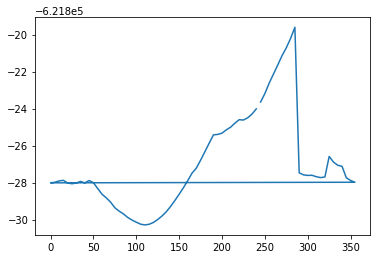

In [9]:
mol = Chem.MolFromMolFile('/auto/nest/nest/u/jsmith/Downloads/drugbank-1250.ipt.mol', removeHs=False)

ts = pya.ani_tortion_scanner(ens)
    
p,e = ts.scan_tortion(mol, [11,12,13,15], 5.0, 72)

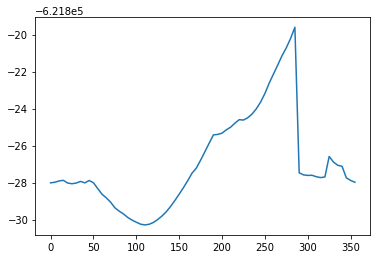

In [11]:
idx = np.argsort(p)

plt.plot(p[idx],e[idx])
plt.show()